In [1]:
import sys
import os
sys.path.append(os.path.abspath(r'C:\Users\Formando\PycharmProjects\slim'))

import pandas as pd
import plotly.graph_objects as go

from slim_gsgp.config.gp_config import *
from slim_gsgp.main_gp import gp  # import the slim_gsgp library
from slim_gsgp.datasets.data_loader import load_airfoil  # import the loader for the dataset PPB
from slim_gsgp.evaluators.fitness_functions import rmse  # import the rmse fitness metric
from slim_gsgp.utils.utils import train_test_split  # import the train-test split function

# Load the Airfoil dataset
X, y = load_airfoil(X_y=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.4)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.5)


local_var = {
    "log_path": "./log/gp_airfoil.csv",
    "dataset_name": "airfoil",
    "pop_size": 50, # size of the population of candidate solutions.
    "n_iter": 100,
    "p_xo": .9, # probability of applying the cross-over genetic operator to candidate solutions.
    "elitism": True,
    "n_elites": 1,
    "max_depth": 7,
    "init_depth": 4,
    "seed": 1111,
    "log_level": 2,
    "verbose": 1,
    "minimization": True,
    "fitness_function": "rmse",
    "initializer": "grow",
    "n_jobs": 1,
    "prob_const": .9,
    "tree_functions": list(FUNCTIONS.keys()),
    "tree_constants": [float(key.replace("constant_", "").replace("_", "-")) for key in CONSTANTS],
    "tournament_size": 2,
    "test_elite": True
}



In [2]:
# Apply the GP algorithm
final_tree = gp(X_train=X_train, y_train=y_train,
                X_test=X_val, y_test=y_val,
                **local_var)

# Show the best individual structure at the last generation
final_tree.print_tree_representation()

# Get the prediction of the best individual on the test set
predictions = final_tree.predict(X_test)

# Compute and print the RMSE on the test set
print(float(rmse(y_true=y_test, y_pred=predictions)))

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     airfoil             |       0      |   38.03727722167969   |   39.9749641418457       |   0.04495978355407715  |      3           |
|     airfoil             |       1      |   38.03727722167969   |   39.9749641418457       |   0.007996559143066406 |      3           |
|     airfoil             |       2      |   38.03727722167969   |   39.9749641418457       |   0.008998632431030273 |      3           |
|     airfoil             |       3      |   38.03727722167969   |   39.9749641418457       |   0.00800180435180664  |      3           |
|     airfoil    

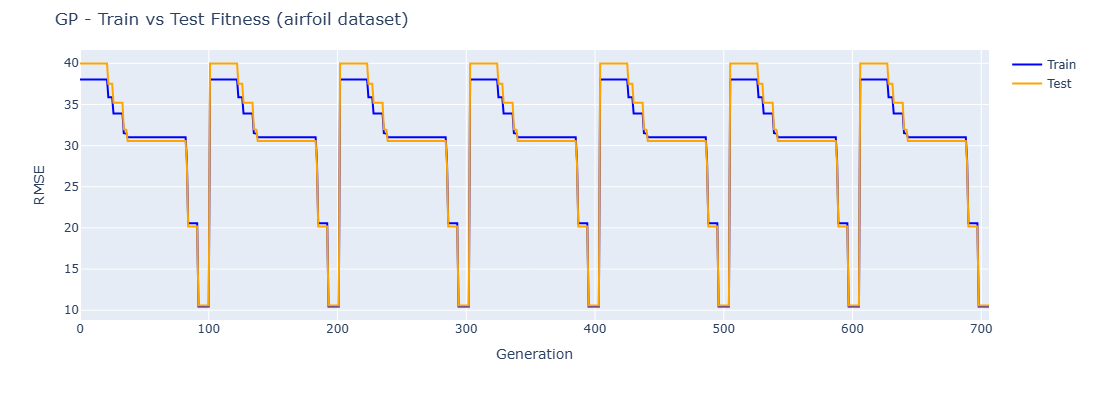

In [3]:
train_color = 'blue'
test_color = 'orange'

fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(local_var["log_path"], header=None).iloc[:, 5].values,
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(local_var["log_path"], header=None).iloc[:, 8].values,
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800,
    margin=dict(t=50),
    yaxis_range=[0, None],
    title_text='GP - Train vs Test Fitness (' + local_var["dataset_name"] + ' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()